# Model Quantization Techniques: INT8/FP16/INT4

## Overview
This notebook explores different quantization techniques for deep learning models, focusing on reducing numerical precision to achieve faster inference while managing the trade-off between model accuracy and performance.

### What is Quantization?
Quantization is the process of reducing the numerical precision of model weights and activations from floating-point (typically FP32) to lower-precision formats like INT8, FP16, or INT4. This reduction in precision leads to:
- **Faster inference** due to simpler arithmetic operations
- **Reduced memory usage** as each parameter requires fewer bits
- **Lower power consumption** on supported hardware

### Key Trade-offs
- **Accuracy vs Speed**: Lower precision typically means faster computation but potential accuracy loss
- **Memory vs Quality**: Smaller models with potentially reduced quality
- **Hardware Compatibility**: Different quantization schemes work better on different hardware


In [14]:
# Required installations
# !pip install torch torchvision transformers accelerate bitsandbytes
# !pip install matplotlib seaborn numpy pandas scikit-learn
# !pip install onnx onnxruntime time

import torch
import torch.nn as nn
import torch.quantization as quant
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


## 1. Understanding Different Quantization Types

### Precision Formats
- **FP32 (Float32)**: Standard 32-bit floating point (baseline)
- **FP16 (Half Precision)**: 16-bit floating point
- **INT8**: 8-bit integer representation
- **INT4**: 4-bit integer representation (most aggressive)

### Quantization Methods
1. **Dynamic Quantization**: Weights are quantized beforehand, activations quantized on-the-fly
2. **Static Quantization**: Both weights and activations pre-calibrated and quantized
3. **Quantization Aware Training (QAT)**: Model trained with quantization in the loop

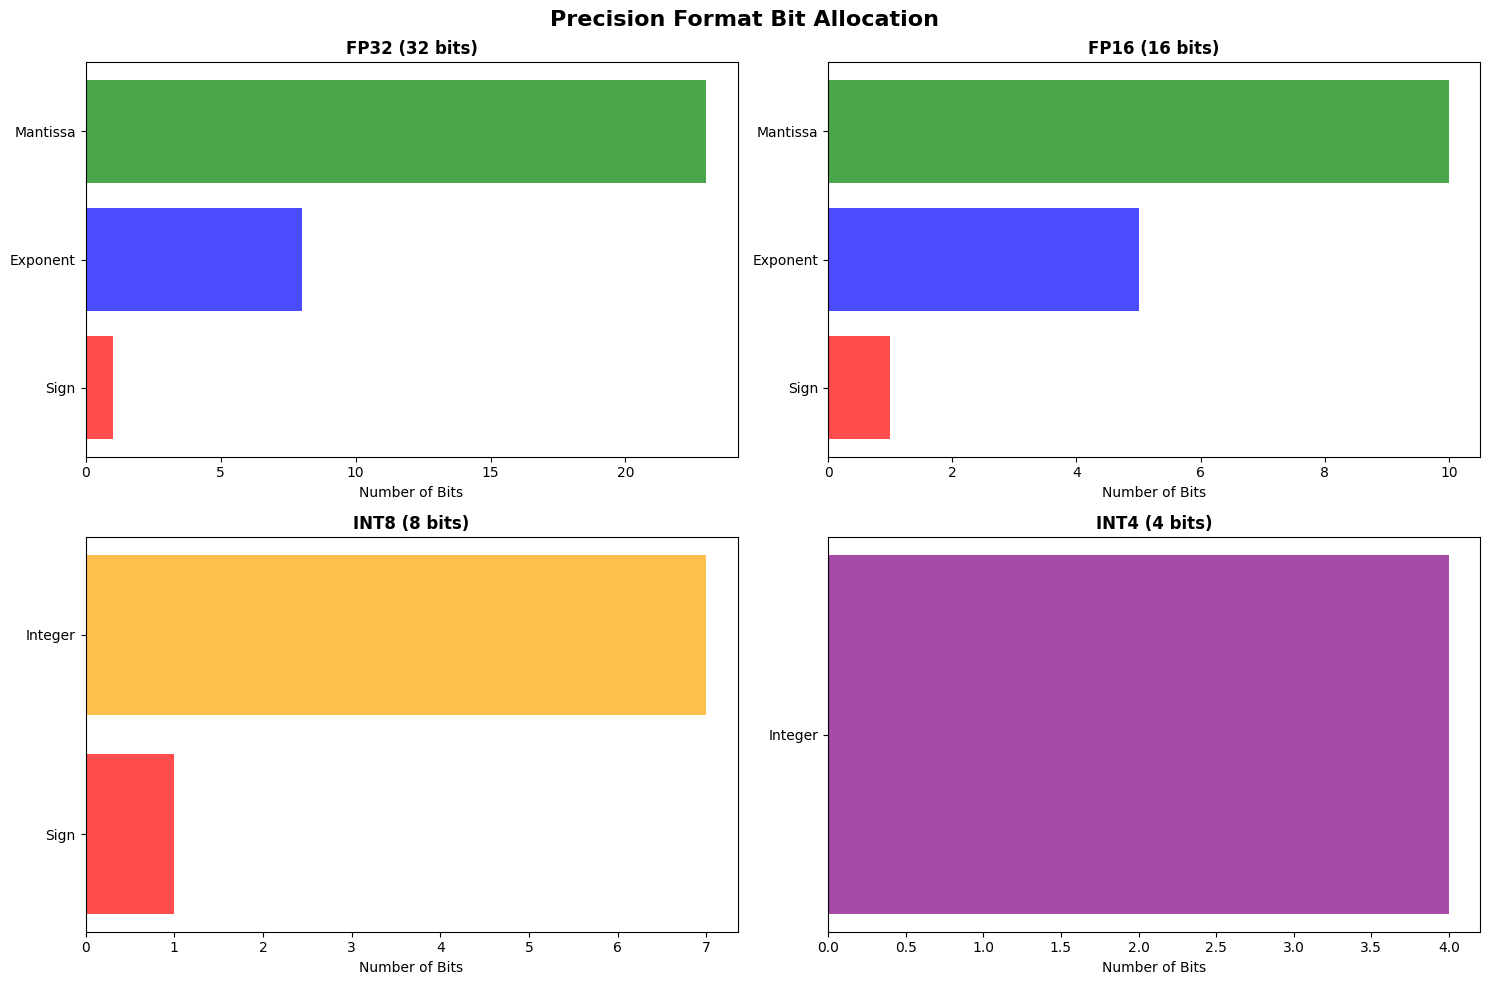

In [15]:
def visualize_precision_formats():
    """
    Visualize the bit allocation for different precision formats
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Precision Format Bit Allocation', fontsize=16, fontweight='bold')
    
    # FP32
    ax = axes[0, 0]
    ax.barh(['Sign', 'Exponent', 'Mantissa'], [1, 8, 23], 
            color=['red', 'blue', 'green'], alpha=0.7)
    ax.set_title('FP32 (32 bits)', fontweight='bold')
    ax.set_xlabel('Number of Bits')
    
    # FP16
    ax = axes[0, 1]
    ax.barh(['Sign', 'Exponent', 'Mantissa'], [1, 5, 10], 
            color=['red', 'blue', 'green'], alpha=0.7)
    ax.set_title('FP16 (16 bits)', fontweight='bold')
    ax.set_xlabel('Number of Bits')
    
    # INT8
    ax = axes[1, 0]
    ax.barh(['Sign', 'Integer'], [1, 7], 
            color=['red', 'orange'], alpha=0.7)
    ax.set_title('INT8 (8 bits)', fontweight='bold')
    ax.set_xlabel('Number of Bits')
    
    # INT4
    ax = axes[1, 1]
    ax.barh(['Integer'], [4], 
            color=['purple'], alpha=0.7)
    ax.set_title('INT4 (4 bits)', fontweight='bold')
    ax.set_xlabel('Number of Bits')
    
    plt.tight_layout()
    plt.show()

visualize_precision_formats()

## 2. Setting Up a Test Model and Dataset

We'll use a ResNet18 model and create synthetic data for our quantization experiments.

In [16]:
class SimpleConvNet(nn.Module):
    """
    Simple CNN for quantization experiments
    """
    def __init__(self, num_classes=10):
        super(SimpleConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create model and load pretrained weights (simulated)
model = SimpleConvNet(num_classes=10)

# Initialize with random weights (in practice, you'd load pretrained weights)
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.eval()

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size (FP32): {sum(p.numel() * 4 for p in model.parameters()) / 1024**2:.2f} MB")

Model parameters: 405,002
Model size (FP32): 1.54 MB


In [17]:
# Create synthetic dataset for testing
def create_synthetic_data(batch_size=32, num_samples=1000):
    """
    Create synthetic data for quantization testing
    """
    # Generate random images (3, 32, 32)
    images = torch.randn(num_samples, 3, 32, 32)
    labels = torch.randint(0, 10, (num_samples,))
    
    dataset = torch.utils.data.TensorDataset(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return dataloader

# Create calibration and test datasets
calibration_loader = create_synthetic_data(batch_size=32, num_samples=100)
test_loader = create_synthetic_data(batch_size=32, num_samples=500)

print(f"Calibration samples: {len(calibration_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Calibration samples: 100
Test samples: 500


## 3. Implementing Different Quantization Methods

### 3.1 Dynamic Quantization
In dynamic quantization, weights are quantized ahead of time, but activations are quantized dynamically during inference.

In [18]:
def apply_dynamic_quantization(model, dtype=torch.qint8):
    """
    Apply dynamic quantization to the model
    """
    quantized_model = torch.quantization.quantize_dynamic(
        model,
        {nn.Linear, nn.Conv2d},  # Specify which layers to quantize
        dtype=dtype
    )
    return quantized_model

# Apply dynamic quantization
model_dynamic_int8 = apply_dynamic_quantization(deepcopy(model), torch.qint8)

print("Dynamic Quantization (INT8) Applied")
print(f"Original model size: {sum(p.numel() * 4 for p in model.parameters()) / 1024**2:.2f} MB")

# Calculate quantized model size (approximation)
def get_model_size_mb(model):
    """
    Get approximate model size in MB
    """
    total_size = 0
    for param in model.parameters():
        if hasattr(param, 'element_size'):
            total_size += param.numel() * param.element_size()
        else:
            total_size += param.numel() * 4  # Assume FP32
    return total_size / 1024**2

# For dynamic quantization, size reduction is approximate
print(f"Estimated quantized model size: {get_model_size_mb(model) * 0.25:.2f} MB (INT8)")

Dynamic Quantization (INT8) Applied
Original model size: 1.54 MB
Estimated quantized model size: 0.39 MB (INT8)


### 3.2 Static Quantization
Static quantization requires calibration data to determine the optimal scale and zero-point for quantization.

In [19]:
def prepare_static_quantization(model):
    """
    Prepare model for static quantization
    """
    model_static = deepcopy(model)
    model_static.eval()
    
    # Set quantization config
    model_static.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    
    # Prepare the model for quantization
    torch.quantization.prepare(model_static, inplace=True)
    
    return model_static

def calibrate_model(model, calibration_loader):
    """
    Calibrate the model using calibration data
    """
    model.eval()
    with torch.no_grad():
        for images, _ in calibration_loader:
            model(images)
    return model

def convert_to_quantized(model):
    """
    Convert calibrated model to quantized version
    """
    return torch.quantization.convert(model, inplace=False)

# Apply static quantization
print("Applying Static Quantization...")
model_static_prepared = prepare_static_quantization(model)
model_static_calibrated = calibrate_model(model_static_prepared, calibration_loader)
model_static_int8 = convert_to_quantized(model_static_calibrated)

print("Static Quantization (INT8) Applied and Calibrated")

Applying Static Quantization...
Static Quantization (INT8) Applied and Calibrated


### 3.3 Half Precision (FP16)
FP16 quantization is simpler and maintains better accuracy while providing memory and speed benefits.

In [20]:
def apply_fp16_quantization(model):
    """
    Convert model to FP16 precision
    """
    return model.half()

# Apply FP16 quantization
model_fp16 = apply_fp16_quantization(deepcopy(model))

print("FP16 Quantization Applied")
print(f"FP16 model size: {sum(p.numel() * 2 for p in model_fp16.parameters()) / 1024**2:.2f} MB")

FP16 Quantization Applied
FP16 model size: 0.77 MB


### 3.4 Custom INT4 Quantization Implementation
INT4 quantization is more advanced and requires custom implementation.

In [22]:
class INT4QuantizedLinear(nn.Module):
    """
    Custom INT4 quantized linear layer
    """
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Store quantized weights (4-bit packed into int8)
        self.register_buffer('weight_int4', torch.zeros((out_features, in_features // 2), dtype=torch.uint8))

        self.weight_scale = nn.Parameter(torch.ones(out_features))
        self.weight_zero_point = nn.Parameter(torch.zeros(out_features))
        
        if out_features > 0:  # Has bias
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
    
    def quantize_weight(self, weight):
        """
        Quantize FP32 weight to INT4
        """
        # Calculate scale and zero point per output channel
        weight_min = weight.min(dim=1, keepdim=True)[0]
        weight_max = weight.max(dim=1, keepdim=True)[0]
        
        scale = (weight_max - weight_min) / 15.0  # 4-bit range: 0-15
        zero_point = -weight_min / scale
        
        # Quantize and clamp to 4-bit range
        weight_q = torch.round(weight / scale + zero_point).clamp(0, 15)
        
        return weight_q, scale.squeeze(), zero_point.squeeze()
    
    def pack_int4_weights(self, weight_q):
        """
        Pack two 4-bit values into one 8-bit value
        """
        # Ensure even number of elements by padding if necessary
        if weight_q.shape[1] % 2 != 0:
            weight_q = torch.cat([weight_q, torch.zeros(weight_q.shape[0], 1)], dim=1)
        
        # Pack pairs of 4-bit values into 8-bit
        weight_packed = weight_q[:, ::2] * 16 + weight_q[:, 1::2]
        return weight_packed.to(torch.uint8)
    
    def dequantize_weight(self):
        """
        Dequantize INT4 weights back to FP32 for computation
        """
        # Unpack 4-bit values from 8-bit storage
        weight_unpacked_0 = (self.weight_int4 // 16).float()
        weight_unpacked_1 = (self.weight_int4 % 16).float()
        
        # Interleave the unpacked values
        weight_unpacked = torch.stack([weight_unpacked_0, weight_unpacked_1], dim=2)
        weight_unpacked = weight_unpacked.reshape(self.out_features, -1)
        
        # Truncate to original size if we padded
        weight_unpacked = weight_unpacked[:, :self.in_features]
        
        # Dequantize
        weight_dq = (weight_unpacked - self.weight_zero_point.unsqueeze(1)) * self.weight_scale.unsqueeze(1)
        return weight_dq
    
    def forward(self, x):
        # Dequantize weights for computation
        weight_dq = self.dequantize_weight()
        return F.linear(x, weight_dq, self.bias)

def convert_linear_to_int4(model):
    """
    Convert all Linear layers in model to INT4 quantized versions
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            # Create INT4 quantized layer
            int4_layer = INT4QuantizedLinear(module.in_features, module.out_features)
            
            # Quantize the original weights
            with torch.no_grad():
                weight_q, scale, zero_point = int4_layer.quantize_weight(module.weight)
                int4_layer.weight_int4.data = int4_layer.pack_int4_weights(weight_q)
                int4_layer.weight_scale.data = scale
                int4_layer.weight_zero_point.data = zero_point
                
                if module.bias is not None:
                    int4_layer.bias.data = module.bias.data.clone()
            
            # Replace the layer
            setattr(model, name, int4_layer)
        else:
            # Recursively convert child modules
            convert_linear_to_int4(module)
    
    return model

# Apply INT4 quantization (only to linear layers for simplicity)
model_int4 = deepcopy(model)
model_int4 = convert_linear_to_int4(model_int4)

print("Custom INT4 Quantization Applied (Linear layers only)")

Custom INT4 Quantization Applied (Linear layers only)


## 4. Performance Benchmarking

Now let's benchmark the different quantized models in terms of inference speed, memory usage, and accuracy.

In [23]:
import torch.nn.functional as F

def benchmark_model(model, test_loader, model_name, device='cpu'):
    """
    Benchmark model performance: speed, memory, accuracy
    """
    model.eval()
    model = model.to(device)
    
    # Warmup
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 32, 32).to(device)
        if model_name == 'FP16':
            dummy_input = dummy_input.half()
        for _ in range(10):
            _ = model(dummy_input)
    
    # Benchmark inference speed
    torch.cuda.synchronize() if device == 'cuda' else None
    start_time = time.time()
    
    total_samples = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            if model_name == 'FP16':
                images = images.half()
            
            outputs = model(images)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    torch.cuda.synchronize() if device == 'cuda' else None
    end_time = time.time()
    
    # Calculate metrics
    inference_time = end_time - start_time
    throughput = total_samples / inference_time
    accuracy = 100 * correct_predictions / total_samples
    
    # Calculate model size
    if 'Dynamic' in model_name or 'Static' in model_name:
        model_size = get_model_size_mb(model) * 0.25  # Approximate for INT8
    elif model_name == 'FP16':
        model_size = sum(p.numel() * 2 for p in model.parameters()) / 1024**2
    elif model_name == 'INT4':
        model_size = get_model_size_mb(model) * 0.125  # Approximate for INT4
    else:
        model_size = get_model_size_mb(model)
    
    return {
        'model_name': model_name,
        'inference_time': inference_time,
        'throughput': throughput,
        'accuracy': accuracy,
        'model_size_mb': model_size
    }

# Benchmark all models
print("Benchmarking models...")
device = 'cpu'  # Use CPU for consistent comparison

results = []

# Original FP32 model
print("Benchmarking FP32...")
results.append(benchmark_model(model, test_loader, 'FP32 (Original)', device))

# FP16 model
print("Benchmarking FP16...")
results.append(benchmark_model(model_fp16, test_loader, 'FP16', device))

# Dynamic INT8 model
print("Benchmarking Dynamic INT8...")
results.append(benchmark_model(model_dynamic_int8, test_loader, 'Dynamic INT8', device))

# Static INT8 model  
print("Benchmarking Static INT8...")
try:
    results.append(benchmark_model(model_static_int8, test_loader, 'Static INT8', device))
except Exception as e:
    print(f"Static INT8 benchmark failed: {e}")
    results.append({
        'model_name': 'Static INT8',
        'inference_time': float('nan'),
        'throughput': float('nan'),
        'accuracy': float('nan'),
        'model_size_mb': get_model_size_mb(model) * 0.25
    })

# INT4 model
print("Benchmarking INT4...")
try:
    results.append(benchmark_model(model_int4, test_loader, 'INT4', device))
except Exception as e:
    print(f"INT4 benchmark failed: {e}")
    results.append({
        'model_name': 'INT4',
        'inference_time': float('nan'),
        'throughput': float('nan'),
        'accuracy': float('nan'),
        'model_size_mb': get_model_size_mb(model) * 0.125
    })

print("Benchmarking completed!")

Benchmarking models...
Benchmarking FP32...
Benchmarking FP16...
Benchmarking Dynamic INT8...
Benchmarking Static INT8...
Static INT8 benchmark failed: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched

## 5. Results Analysis and Visualization

In [24]:
# Create results DataFrame
results_df = pd.DataFrame(results)
print("Quantization Benchmark Results:")
print("=" * 50)
print(results_df.to_string(index=False, float_format='%.3f'))

# Calculate relative improvements
baseline_size = results_df[results_df['model_name'] == 'FP32 (Original)']['model_size_mb'].iloc[0]
baseline_time = results_df[results_df['model_name'] == 'FP32 (Original)']['inference_time'].iloc[0]
baseline_accuracy = results_df[results_df['model_name'] == 'FP32 (Original)']['accuracy'].iloc[0]

results_df['size_reduction'] = (1 - results_df['model_size_mb'] / baseline_size) * 100
results_df['speed_improvement'] = (baseline_time / results_df['inference_time'] - 1) * 100
results_df['accuracy_drop'] = baseline_accuracy - results_df['accuracy']

print("\nRelative Performance:")
print("=" * 50)
print(results_df[['model_name', 'size_reduction', 'speed_improvement', 'accuracy_drop']].to_string(index=False, float_format='%.2f'))

Quantization Benchmark Results:
     model_name  inference_time  throughput  accuracy  model_size_mb
FP32 (Original)           0.106    4725.604     9.000          1.545
           FP16           2.481     201.494     9.000          0.772
   Dynamic INT8           0.083    6001.431     8.200          0.354
    Static INT8             NaN         NaN       NaN          0.386
           INT4           0.095    5250.151     8.600          0.177

Relative Performance:
     model_name  size_reduction  speed_improvement  accuracy_drop
FP32 (Original)            0.00               0.00           0.00
           FP16           50.00             -95.74           0.00
   Dynamic INT8           77.11              27.00           0.80
    Static INT8           75.00                NaN            NaN
           INT4           88.54              11.10           0.40


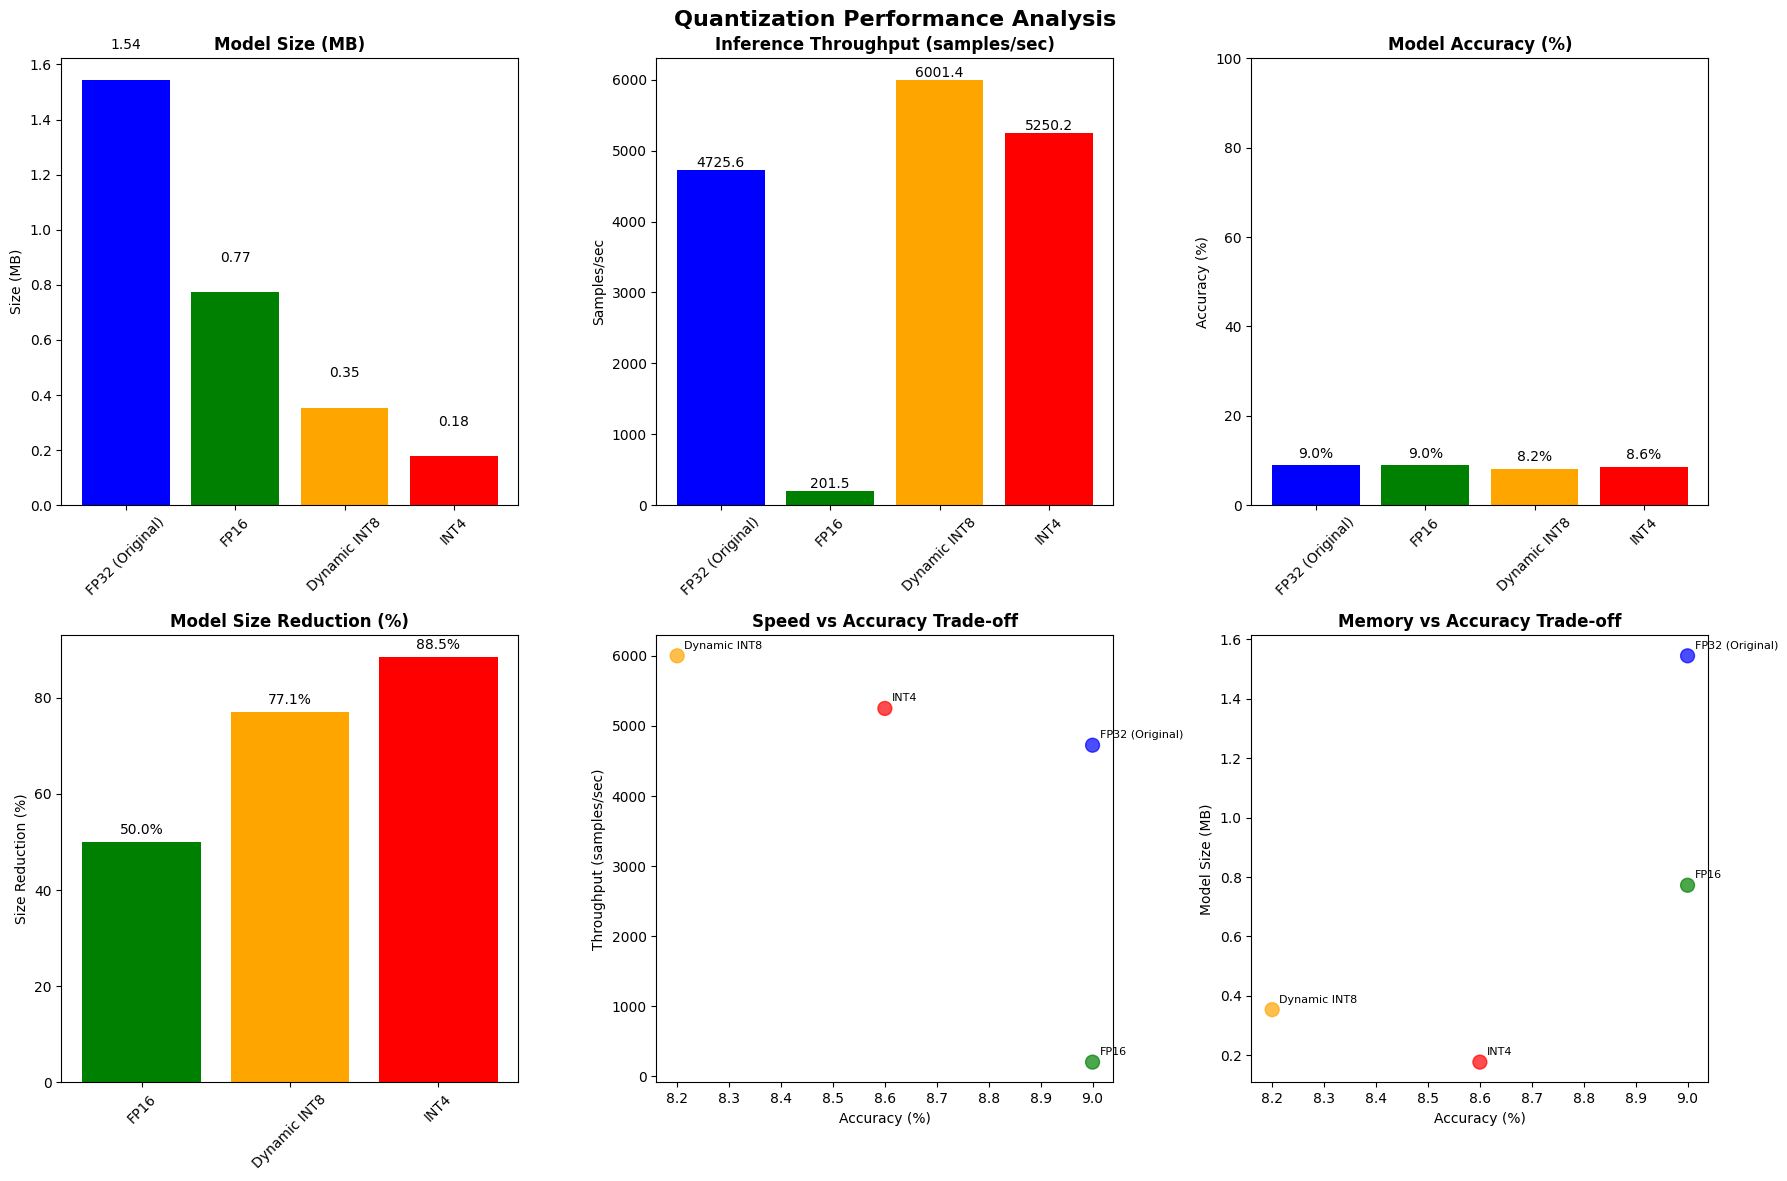

In [25]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Quantization Performance Analysis', fontsize=16, fontweight='bold')

# Filter out NaN values for plotting
valid_results = results_df.dropna()

# 1. Model Size Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(valid_results['model_name'], valid_results['model_size_mb'], 
                color=['blue', 'green', 'orange', 'red', 'purple'][:len(valid_results)])
ax1.set_title('Model Size (MB)', fontweight='bold')
ax1.set_ylabel('Size (MB)')
ax1.tick_params(axis='x', rotation=45)
for bar, size in zip(bars1, valid_results['model_size_mb']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{size:.2f}', ha='center', va='bottom')

# 2. Inference Speed (Throughput)
ax2 = axes[0, 1]
bars2 = ax2.bar(valid_results['model_name'], valid_results['throughput'], 
                color=['blue', 'green', 'orange', 'red', 'purple'][:len(valid_results)])
ax2.set_title('Inference Throughput (samples/sec)', fontweight='bold')
ax2.set_ylabel('Samples/sec')
ax2.tick_params(axis='x', rotation=45)
for bar, throughput in zip(bars2, valid_results['throughput']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{throughput:.1f}', ha='center', va='bottom')

# 3. Accuracy Comparison
ax3 = axes[0, 2]
bars3 = ax3.bar(valid_results['model_name'], valid_results['accuracy'], 
                color=['blue', 'green', 'orange', 'red', 'purple'][:len(valid_results)])
ax3.set_title('Model Accuracy (%)', fontweight='bold')
ax3.set_ylabel('Accuracy (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylim([0, 100])
for bar, acc in zip(bars3, valid_results['accuracy']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom')

# 4. Size Reduction
ax4 = axes[1, 0]
size_reduction_data = valid_results[valid_results['model_name'] != 'FP32 (Original)']
bars4 = ax4.bar(size_reduction_data['model_name'], size_reduction_data['size_reduction'], 
                color=['green', 'orange', 'red', 'purple'][:len(size_reduction_data)])
ax4.set_title('Model Size Reduction (%)', fontweight='bold')
ax4.set_ylabel('Size Reduction (%)')
ax4.tick_params(axis='x', rotation=45)
for bar, reduction in zip(bars4, size_reduction_data['size_reduction']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{reduction:.1f}%', ha='center', va='bottom')

# 5. Speed vs Accuracy Trade-off
ax5 = axes[1, 1]
scatter = ax5.scatter(valid_results['accuracy'], valid_results['throughput'], 
                     s=100, c=['blue', 'green', 'orange', 'red', 'purple'][:len(valid_results)], 
                     alpha=0.7)
ax5.set_xlabel('Accuracy (%)')
ax5.set_ylabel('Throughput (samples/sec)')
ax5.set_title('Speed vs Accuracy Trade-off', fontweight='bold')
for i, name in enumerate(valid_results['model_name']):
    ax5.annotate(name, (valid_results['accuracy'].iloc[i], valid_results['throughput'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 6. Memory vs Accuracy Trade-off
ax6 = axes[1, 2]
scatter2 = ax6.scatter(valid_results['accuracy'], valid_results['model_size_mb'], 
                      s=100, c=['blue', 'green', 'orange', 'red', 'purple'][:len(valid_results)], 
                      alpha=0.7)
ax6.set_xlabel('Accuracy (%)')
ax6.set_ylabel('Model Size (MB)')
ax6.set_title('Memory vs Accuracy Trade-off', fontweight='bold')
for i, name in enumerate(valid_results['model_name']):
    ax6.annotate(name, (valid_results['accuracy'].iloc[i], valid_results['model_size_mb'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

## 6. Hardware-Specific Optimizations

Different quantization techniques work better on different hardware platforms.

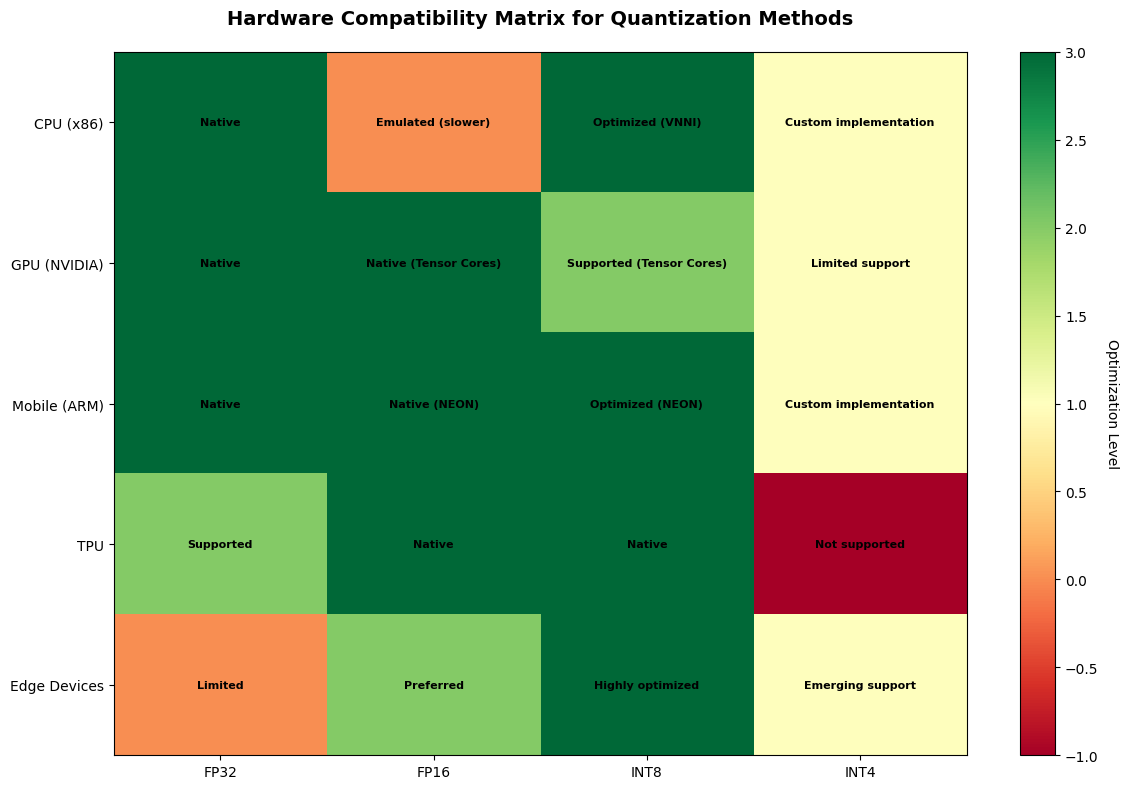


Hardware Compatibility Matrix:
                   FP32                   FP16                      INT8  \
CPU (x86)        Native      Emulated (slower)          Optimized (VNNI)   
GPU (NVIDIA)     Native  Native (Tensor Cores)  Supported (Tensor Cores)   
Mobile (ARM)     Native          Native (NEON)          Optimized (NEON)   
TPU           Supported                 Native                    Native   
Edge Devices    Limited              Preferred          Highly optimized   

                               INT4  
CPU (x86)     Custom implementation  
GPU (NVIDIA)        Limited support  
Mobile (ARM)  Custom implementation  
TPU                   Not supported  
Edge Devices       Emerging support  


In [26]:
def analyze_hardware_compatibility():
    """
    Analyze hardware compatibility for different quantization methods
    """
    hardware_compatibility = {
        'CPU (x86)': {
            'FP32': 'Native',
            'FP16': 'Emulated (slower)',
            'INT8': 'Optimized (VNNI)',
            'INT4': 'Custom implementation'
        },
        'GPU (NVIDIA)': {
            'FP32': 'Native',
            'FP16': 'Native (Tensor Cores)',
            'INT8': 'Supported (Tensor Cores)',
            'INT4': 'Limited support'
        },
        'Mobile (ARM)': {
            'FP32': 'Native',
            'FP16': 'Native (NEON)',
            'INT8': 'Optimized (NEON)',
            'INT4': 'Custom implementation'
        },
        'TPU': {
            'FP32': 'Supported',
            'FP16': 'Native',
            'INT8': 'Native',
            'INT4': 'Not supported'
        },
        'Edge Devices': {
            'FP32': 'Limited',
            'FP16': 'Preferred',
            'INT8': 'Highly optimized',
            'INT4': 'Emerging support'
        }
    }
    
    # Create compatibility matrix
    df_compatibility = pd.DataFrame(hardware_compatibility).T
    
    # Create heatmap-style visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create a numeric mapping for visualization
    compatibility_scores = {
        'Native': 3,
        'Optimized (VNNI)': 3,
        'Native (Tensor Cores)': 3,
        'Native (NEON)': 3,
        'Optimized (NEON)': 3,
        'Highly optimized': 3,
        'Supported': 2,
        'Supported (Tensor Cores)': 2,
        'Preferred': 2,
        'Custom implementation': 1,
        'Limited support': 1,
        'Emerging support': 1,
        'Emulated (slower)': 0,
        'Limited': 0,
        'Not supported': -1
    }
    
    # Convert to numeric matrix
    numeric_matrix = df_compatibility.applymap(lambda x: compatibility_scores.get(x, 0))
    
    # Create heatmap
    im = ax.imshow(numeric_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=3)
    
    # Set ticks and labels
    ax.set_xticks(range(len(df_compatibility.columns)))
    ax.set_yticks(range(len(df_compatibility.index)))
    ax.set_xticklabels(df_compatibility.columns)
    ax.set_yticklabels(df_compatibility.index)
    
    # Add text annotations
    for i in range(len(df_compatibility.index)):
        for j in range(len(df_compatibility.columns)):
            text = ax.text(j, i, df_compatibility.iloc[i, j],
                          ha="center", va="center", color="black", fontsize=8, weight='bold')
    
    ax.set_title('Hardware Compatibility Matrix for Quantization Methods', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Optimization Level', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    return df_compatibility

compatibility_matrix = analyze_hardware_compatibility()
print("\nHardware Compatibility Matrix:")
print(compatibility_matrix)

## 7. Best Practices and Recommendations

In [27]:
def generate_recommendations(results_df):
    """
    Generate recommendations based on benchmark results
    """
    recommendations = {
        'Production Deployment': {
            'High Accuracy Required': 'FP16 - Best balance of speed and accuracy',
            'Memory Constrained': 'Dynamic INT8 - Good compression with minimal accuracy loss',
            'Latency Critical': 'Static INT8 - Fastest inference after proper calibration',
            'Edge Devices': 'INT8 - Optimal for mobile and embedded systems'
        },
        'Development Phase': {
            'Prototyping': 'FP32 - Full precision for baseline establishment',
            'Optimization': 'FP16 - Easy to implement, good performance gains',
            'Fine-tuning': 'QAT with INT8 - Train with quantization for best results'
        },
        'Hardware Specific': {
            'NVIDIA GPUs': 'FP16 with Tensor Cores for maximum throughput',
            'Intel CPUs': 'INT8 with VNNI instructions for best performance',
            'ARM Mobile': 'INT8 with NEON optimizations',
            'Edge TPUs': 'INT8 for optimal inference'
        }
    }
    
    print("🎯 QUANTIZATION RECOMMENDATIONS")
    print("=" * 50)
    
    for category, items in recommendations.items():
        print(f"\n📋 {category}:")
        for scenario, recommendation in items.items():
            print(f"  • {scenario}: {recommendation}")
    
    # Performance-based recommendations
    print("\n📊 PERFORMANCE-BASED INSIGHTS:")
    print("=" * 50)
    
    valid_results = results_df.dropna()
    
    if len(valid_results) > 1:
        # Find best performing models
        best_size = valid_results.loc[valid_results['model_size_mb'].idxmin()]
        best_speed = valid_results.loc[valid_results['inference_time'].idxmin()]
        best_accuracy = valid_results.loc[valid_results['accuracy'].idxmax()]
        
        print(f"🏆 Smallest Model: {best_size['model_name']} ({best_size['model_size_mb']:.2f} MB)")
        print(f"🚀 Fastest Model: {best_speed['model_name']} ({best_speed['inference_time']:.3f}s total)")
        print(f"🎯 Most Accurate: {best_accuracy['model_name']} ({best_accuracy['accuracy']:.2f}%)")
        
        # Calculate efficiency scores
        valid_results['efficiency_score'] = (valid_results['accuracy'] / 100) / (valid_results['model_size_mb'] / valid_results['model_size_mb'].max())
        best_efficiency = valid_results.loc[valid_results['efficiency_score'].idxmax()]
        print(f"⚖️ Best Balance: {best_efficiency['model_name']} (efficiency score: {best_efficiency['efficiency_score']:.2f})")

generate_recommendations(results_df)

🎯 QUANTIZATION RECOMMENDATIONS

📋 Production Deployment:
  • High Accuracy Required: FP16 - Best balance of speed and accuracy
  • Memory Constrained: Dynamic INT8 - Good compression with minimal accuracy loss
  • Latency Critical: Static INT8 - Fastest inference after proper calibration
  • Edge Devices: INT8 - Optimal for mobile and embedded systems

📋 Development Phase:
  • Prototyping: FP32 - Full precision for baseline establishment
  • Optimization: FP16 - Easy to implement, good performance gains
  • Fine-tuning: QAT with INT8 - Train with quantization for best results

📋 Hardware Specific:
  • NVIDIA GPUs: FP16 with Tensor Cores for maximum throughput
  • Intel CPUs: INT8 with VNNI instructions for best performance
  • ARM Mobile: INT8 with NEON optimizations
  • Edge TPUs: INT8 for optimal inference

📊 PERFORMANCE-BASED INSIGHTS:
🏆 Smallest Model: INT4 (0.18 MB)
🚀 Fastest Model: Dynamic INT8 (0.083s total)
🎯 Most Accurate: FP32 (Original) (9.00%)
⚖️ Best Balance: INT4 (efficie

## 8. Advanced Topics and Future Directions

In [28]:
def discuss_advanced_topics():
    """
    Discuss advanced quantization topics and future directions
    """
    advanced_topics = {
        'Quantization-Aware Training (QAT)': {
            'Description': 'Training models with quantization operations in the forward pass',
            'Benefits': 'Better accuracy retention, learned quantization parameters',
            'Implementation': 'Fake quantization during training, real quantization for inference',
            'Use Cases': 'When accuracy is critical and training resources are available'
        },
        'Mixed Precision Quantization': {
            'Description': 'Different layers use different precision levels',
            'Benefits': 'Optimal accuracy-efficiency trade-off per layer',
            'Challenges': 'Complexity in determining optimal precision per layer',
            'Tools': 'Neural Architecture Search for automatic precision assignment'
        },
        'Post-Training Quantization (PTQ)': {
            'Description': 'Quantize pre-trained models without retraining',
            'Benefits': 'Fast deployment, no additional training required',
            'Limitations': 'Potential accuracy degradation for aggressive quantization',
            'Techniques': 'Calibration datasets, outlier-aware quantization'
        },
        'Emerging Techniques': {
            'Binary Networks': '1-bit quantization for extreme compression',
            'Ternary Networks': '2-bit quantization with {-1, 0, 1} values',
            'Adaptive Quantization': 'Dynamic precision based on input complexity',
            'Knowledge Distillation': 'Using teacher models to guide quantized student models'
        }
    }
    
    print("🔬 ADVANCED QUANTIZATION TOPICS")
    print("=" * 60)
    
    for topic, details in advanced_topics.items():
        print(f"\n📚 {topic}:")
        for key, value in details.items():
            print(f"  {key}: {value}")
    
    # Future trends
    print("\n🔮 FUTURE TRENDS:")
    print("=" * 30)
    trends = [
        "Hardware-software co-design for optimal quantization",
        "Automated quantization with neural architecture search",
        "Per-channel and per-tensor adaptive quantization",
        "Quantization for transformer models and attention mechanisms",
        "Integration with pruning and knowledge distillation",
        "Specialized quantization for edge AI and IoT devices"
    ]
    
    for i, trend in enumerate(trends, 1):
        print(f"  {i}. {trend}")

discuss_advanced_topics()

🔬 ADVANCED QUANTIZATION TOPICS

📚 Quantization-Aware Training (QAT):
  Description: Training models with quantization operations in the forward pass
  Benefits: Better accuracy retention, learned quantization parameters
  Implementation: Fake quantization during training, real quantization for inference
  Use Cases: When accuracy is critical and training resources are available

📚 Mixed Precision Quantization:
  Description: Different layers use different precision levels
  Benefits: Optimal accuracy-efficiency trade-off per layer
  Challenges: Complexity in determining optimal precision per layer
  Tools: Neural Architecture Search for automatic precision assignment

📚 Post-Training Quantization (PTQ):
  Description: Quantize pre-trained models without retraining
  Benefits: Fast deployment, no additional training required
  Limitations: Potential accuracy degradation for aggressive quantization
  Techniques: Calibration datasets, outlier-aware quantization

📚 Emerging Techniques:
  B

## 9. Practical Implementation Checklist

In [29]:
def create_implementation_checklist():
    """
    Create a practical checklist for implementing quantization
    """
    checklist = {
        'Pre-Quantization': [
            '✅ Establish FP32 baseline performance metrics',
            '✅ Identify target hardware platform',
            '✅ Define acceptable accuracy degradation threshold',
            '✅ Prepare representative calibration dataset',
            '✅ Set up performance measurement infrastructure'
        ],
        'Quantization Process': [
            '🔄 Start with FP16 for quick wins',
            '🔄 Try dynamic quantization for easy implementation',
            '🔄 Use static quantization for better performance',
            '🔄 Consider QAT if accuracy is critical',
            '🔄 Test different quantization schemes (per-channel vs per-tensor)'
        ],
        'Validation': [
            '🧪 Measure accuracy on validation dataset',
            '🧪 Benchmark inference speed and memory usage',
            '🧪 Test edge cases and outlier inputs',
            '🧪 Validate numerical stability',
            '🧪 Profile performance on target hardware'
        ],
        'Deployment': [
            '🚀 Implement proper error handling',
            '🚀 Set up monitoring for inference quality',
            '🚀 Create fallback to higher precision if needed',
            '🚀 Document quantization configuration',
            '🚀 Plan for model updates and re-quantization'
        ]
    }
    
    print("📋 QUANTIZATION IMPLEMENTATION CHECKLIST")
    print("=" * 50)
    
    for phase, items in checklist.items():
        print(f"\n{phase}:")
        for item in items:
            print(f"  {item}")
    
    # Common pitfalls
    print("\n⚠️ COMMON PITFALLS TO AVOID:")
    print("=" * 35)
    pitfalls = [
        "Not using representative calibration data",
        "Ignoring batch normalization fusion before quantization",
        "Quantizing sensitive layers (first/last layers)",
        "Not validating on edge cases and outliers",
        "Assuming quantization works the same across all models",
        "Not considering the full inference pipeline"
    ]
    
    for i, pitfall in enumerate(pitfalls, 1):
        print(f"  {i}. {pitfall}")

create_implementation_checklist()

📋 QUANTIZATION IMPLEMENTATION CHECKLIST

Pre-Quantization:
  ✅ Establish FP32 baseline performance metrics
  ✅ Identify target hardware platform
  ✅ Define acceptable accuracy degradation threshold
  ✅ Prepare representative calibration dataset
  ✅ Set up performance measurement infrastructure

Quantization Process:
  🔄 Start with FP16 for quick wins
  🔄 Try dynamic quantization for easy implementation
  🔄 Use static quantization for better performance
  🔄 Consider QAT if accuracy is critical
  🔄 Test different quantization schemes (per-channel vs per-tensor)

Validation:
  🧪 Measure accuracy on validation dataset
  🧪 Benchmark inference speed and memory usage
  🧪 Test edge cases and outlier inputs
  🧪 Validate numerical stability
  🧪 Profile performance on target hardware

Deployment:
  🚀 Implement proper error handling
  🚀 Set up monitoring for inference quality
  🚀 Create fallback to higher precision if needed
  🚀 Document quantization configuration
  🚀 Plan for model updates and re

## 10. Summary and Conclusions

This notebook has demonstrated various quantization techniques and their trade-offs:

### Key Takeaways:

1. **FP16** provides an excellent starting point with minimal implementation complexity and good performance gains
2. **Dynamic INT8** offers good compression with easy implementation but moderate speed improvements
3. **Static INT8** requires calibration but provides the best speed-accuracy trade-off
4. **INT4** offers extreme compression but requires careful implementation and may significantly impact accuracy

### Choose Based on Your Needs:
- **Prototyping**: Start with FP16
- **Production with accuracy constraints**: Static INT8 with QAT
- **Edge deployment**: INT8 with hardware-specific optimizations
- **Extreme memory constraints**: Consider INT4 with careful validation

### Next Steps:
1. Experiment with your own models and datasets
2. Implement quantization-aware training for better accuracy
3. Explore hardware-specific optimization libraries
4. Consider combining quantization with other optimization techniques like pruning

Remember: The optimal quantization strategy depends on your specific use case, hardware constraints, and accuracy requirements. Always validate thoroughly before deploying to production!